In [1]:
import os

import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import pickle
import quandl
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt


import scipy.stats as ss

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from quandl.errors.quandl_error import NotFoundError



import sklearn as sk
from sklearn import preprocessing as pr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.signal import correlate
from scipy.stats.mstats import spearmanr
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
'''Retrieve Bitcoin Pricing data using Quandl'''

def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [3]:
'''Pull kraken exchange pricing data'''

quandl_api_key = "sWmNm41Ji9goVFUtnUxe"
quandl.ApiConfig.api_key = quandl_api_key
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [4]:
btc_usd_price_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
Date                                                                   
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
Date                                           
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [5]:
'''Plotting the BTC kraken pricing data'''

btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [6]:
'''Pull pricing data for 3 more BTC exchanges'''

try:
    exchanges = ['COINBASE','BITSTAMP','ITBIT']

    exchange_data = {}

    exchange_data['KRAKEN'] = btc_usd_price_kraken

    for exchange in exchanges:
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
        btc_exchange_df = get_quandl_data(exchange_code)
        exchange_data[exchange] = btc_exchange_df
    
except NotFoundError as e:
         print('error: {} '.format(str(e)))

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [7]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [8]:
'''Merge the BTC price dataseries' into a single dataframe'''
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [9]:
'''Previewing the last 5 rows'''
btc_usd_datasets.tail()

KRAKEN     COINBASE     BITSTAMP        ITBIT
Date                                                          
2018-09-16  6463.753311  6463.503207  6456.389531  6465.736285
2018-09-17  6335.470383  6352.904890  6323.180216  6283.055160
2018-09-18  6306.223215  6306.788616  6305.513155  6307.623402
2018-09-19  6344.751761  6340.783998  6329.133068  6334.001018
2018-09-20  6402.268693  6397.008433  6400.597781  6400.345052

In [10]:
'''The prices look to be as expected: they are in similar ranges, but with slight variations based on the supply and demand of each individual Bitcoin exchange.'''

'''Visualizing the pricing datasets.'''

def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            #visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [11]:
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [12]:
'''Clean and Aggregate the Pricing Data'''

'''Remove all "0" values from dataframe, since BTC price has never been zero.''' 

btc_usd_datasets.replace(0, np.nan, inplace=True)

In [13]:
'''Plot the revised dataframe''' 
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [14]:
'''Calculate the average BTC price as a new column''' 
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

In [15]:
'''Plot the average BTC price'''
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
py.iplot([btc_trace])

In [16]:
'''Define Poloniex API Helper Functions'''

def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [17]:
'''Generate Poloniex API HTTP requests. Call get_json_data() to save the results.'''

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [18]:
'''Download Trading Data From Poloniex'''

'''Downloaded exchange data for the top cryptocurrencies -
Ethereum, Litecoin, Ripple, Ethereum Classic, Stellar, Dash, Siacoin, Monero, NEM, and Zcash'''



altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM', 'ZEC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420041600.0&end=1539588683.822179&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420041600.0&end=1539588683.822179&period=86

In [19]:
altcoin_data['ETH'].tail()

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [20]:
'''Convert Prices to USD'''

# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

In [21]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [22]:
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [23]:
# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

In [24]:
df1 = pd.read_csv('C:\\Users\\ShiviMalhotra\\Desktop\\research material\\cryptocompare_BTC.csv') 

In [25]:
btc_trace = go.Scatter(x=df1['timeDate'], y=df1['volumefrom'])
py.iplot([btc_trace])

In [26]:

def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [27]:
'''Generate binance API HTTP requests. Call get_json_data() to save the results.'''

base_binance_url = 'https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC'
start_date = datetime.strptime('2013-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(binance_pair):
    '''Retrieve cryptocurrency data from binance'''
    json_url = base_binance_url.format(binance_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, binance_pair)
    data_df = data_df.set_index('date')
    return data_df

In [28]:
'''Download Trading Data From Poloniex'''

'''Downloaded exchange data for the top cryptocurrencies -
Ethereum, Litecoin, Ripple, Ethereum Classic, Stellar, Dash, Siacoin, Monero, and NEM.'''



altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM', 'ZEC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache
Loaded https://api.binance.com/api/v1/ticker/price?symbol=LTCBTC from cache


In [29]:
altcoin_data['ETH'].tail()

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [30]:
'''Convert Prices to USD'''

# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

In [31]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [32]:
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [33]:
# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

In [34]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [35]:
'''Generate huobi API HTTP requests. Call get_json_data() to save the results.'''

base_huobi_url = 'https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1'
start_date = datetime.strptime('2013-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(huobi_pair):
    '''Retrieve cryptocurrency data from binance'''
    json_url = base_huobi_url.format(huobi_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, huobi_pair)
    data_df = data_df.set_index('date')
    return data_df

In [36]:
'''Download Trading Data From Poloniex'''

'''Downloaded exchange data for the top cryptocurrencies -
Ethereum, Litecoin, Ripple, Ethereum Classic, Stellar, Dash, Siacoin, Monero, and NEM.'''



altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM', 'ZEC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache
Loaded https://api.huobi.pro/market/depth?symbol=ethbtc&type=step1 from cache


In [37]:
altcoin_data['ETH'].tail()

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [38]:
'''correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column'''

# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df_2016 = combined_df[combined_df.index.year == 2016]
combined_df_2016.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000 -0.064652  0.085630 -0.181991  0.035093  0.122695  0.169642   
LTC  -0.064652  1.000000  0.053712 -0.131079  0.113523 -0.012194  0.012253   
XRP   0.085630  0.053712  1.000000 -0.054095  0.320116  0.088657  0.021098   
ETC  -0.181991 -0.131079 -0.054095  1.000000 -0.102654  0.003992 -0.008066   
STR   0.035093  0.113523  0.320116 -0.102654  1.000000  0.058083  0.143252   
DASH  0.122695 -0.012194  0.088657  0.003992  0.058083  1.000000  0.026602   
SC    0.169642  0.012253  0.021098 -0.008066  0.143252  0.026602  1.000000   
XMR   0.087216  0.129475  0.027649 -0.105898  0.027998  0.121537  0.047910   
XEM   0.043205  0.160667  0.101326 -0.080938  0.225132  0.014571  0.106153   
ZEC   0.112247  0.142880 -0.101774  0.062003 -0.001715  0.040876  0.020958   
BTC  -0.006502  0.750174  0.044161 -0.170538  0.079075 -0.014040  0.035116   

           XMR       XEM       ZEC       BTC  
ETH   0.087216  0.043205  0.112247 -0.006502  
LTC   0.129475  0.160667  0.142880  0.750174  
XRP   0.027649  0.101326 -0.101774  0.044161  
ETC  -0.105898 -0.080938  0.062003 -0.170538  
STR   0.027998  0.225132 -0.001715  0.079075  
DASH  0.121537  0.014571  0.040876 -0.014040  
SC    0.047910  0.106153  0.020958  0.035116  
XMR   1.000000  0.016438  0.106825  0.127520  
XEM   0.016438  1.000000 -0.033197  0.227674  
ZEC   0.106825 -0.033197  1.000000  0.199881  
BTC   0.127520  0.227674  0.199881  1.000000

In [39]:
'''To help visualize these results, we'll create one more helper visualization function.'''

def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [40]:
correlation_heatmap(combined_df_2016.pct_change(), "Cryptocurrency Correlations in 2016")

C:\Users\ShiviMalhotra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [41]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
combined_df_2017.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000  0.437609  0.212350  0.601437  0.259399  0.506911  0.373078   
LTC   0.437609  1.000000  0.323905  0.482062  0.307589  0.340153  0.339144   
XRP   0.212350  0.323905  1.000000  0.114780  0.509828  0.091146  0.243872   
ETC   0.601437  0.482062  0.114780  1.000000  0.210387  0.387555  0.298406   
STR   0.259399  0.307589  0.509828  0.210387  1.000000  0.183038  0.402966   
DASH  0.506911  0.340153  0.091146  0.387555  0.183038  1.000000  0.291424   
SC    0.373078  0.339144  0.243872  0.298406  0.402966  0.291424  1.000000   
XMR   0.554632  0.437204  0.226636  0.447398  0.327488  0.498418  0.378644   
XEM   0.399200  0.379088  0.268168  0.321852  0.339502  0.325968  0.331350   
ZEC   0.539700  0.264172  0.229027  0.410320  0.240921  0.543080  0.278549   
BTC   0.410771  0.420645  0.131469  0.416562  0.230957  0.307095  0.325318   

           XMR       XEM       ZEC       BTC  
ETH   0.554632  0.399200  0.539700  0.410771  
LTC   0.437204  0.379088  0.264172  0.420645  
XRP   0.226636  0.268168  0.229027  0.131469  
ETC   0.447398  0.321852  0.410320  0.416562  
STR   0.327488  0.339502  0.240921  0.230957  
DASH  0.498418  0.325968  0.543080  0.307095  
SC    0.378644  0.331350  0.278549  0.325318  
XMR   1.000000  0.336076  0.461947  0.409183  
XEM   0.336076  1.000000  0.381487  0.329431  
ZEC   0.461947  0.381487  1.000000  0.291353  
BTC   0.409183  0.329431  0.291353  1.000000

In [42]:
correlation_heatmap(combined_df_2017.pct_change(), "Cryptocurrency Correlations in 2017")

C:\Users\ShiviMalhotra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [43]:
base_polo_url = 'https://bitcoinchain.com/markets/btcusd-okcoin'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

# Helper function to download and cache JSON data; returns a DF
def get_json_data(json_url, cache_path):
    try:        
        with open(cache_path, 'rb') as f:
            df = pickle.load(f)   
            print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

# Retrieve cryptocurrency data from Poloniex
def get_crypto_data(poloniex_pair):
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

coinpair = 'BTC_{}'.format('ETH')
df = get_crypto_data(coinpair)
df.tail()

Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache


close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [44]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache


In [45]:
altcoin_data['ETH'].tail(3)

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [46]:
altcoin_data['LTC'].tail(3)

close      high       low      open   quoteVolume     volume  \
date                                                                          
2018-09-19  0.008510  0.008620  0.008311  0.008520  10220.869503  86.455763   
2018-09-20  0.008706  0.008808  0.008347  0.008508  10774.233214  92.057037   
2018-09-21  0.008692  0.008791  0.008675  0.008709   3460.015087  30.150025   

            weightedAverage  
date                         
2018-09-19         0.008459  
2018-09-20         0.008544  
2018-09-21         0.008714

In [47]:
import quandl
import pickle
from pandas import DataFrame


# Define a helper function to download and cache datasets from Quandl
def get_quandl_data(quandl_id):
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        with open(cache_path, 'rb') as f:
            df = pickle.load(f)   
            print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns='pandas')
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

# Retrieve Bitcoin data from several exchanges
exchanges = ['COINBASE', 'KRAKEN', 'BITSTAMP','ITBIT']
exchange_data = {}
for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    df = get_quandl_data(exchange_code)
    exchange_data[exchange] = df
    

# Helper function to merge a single column of each DF into a new combined DF
def merge_dfs_on_column(dataframes, labels, col):
    d = {labels[i]:dataframes[i][col] for i in range(len(dataframes))}       
    return DataFrame(d)
    
# Merge the BTC prices into a single DF
# Note that we'll only use the "Weighted Price" column
btc_usd_datasets = merge_dfs_on_column(dataframes=list(exchange_data.values()), 
                                       labels=list(exchange_data.keys()), 
                                       col='Weighted Price')

# Show the last 10 rows of Bitcoin prices
btc_usd_datasets.tail(10)

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


COINBASE       KRAKEN     BITSTAMP        ITBIT
Date                                                          
2018-09-11  6278.697291  6279.709928  6284.683155  6282.415427
2018-09-12  6273.257514  6278.397725  6267.795821  6268.275606
2018-09-13  6450.296453  6477.539409  6460.090136  6452.828573
2018-09-14  6495.983961  6502.085248  6492.115618  6490.428834
2018-09-15  6521.556675  6516.699234  6518.938313  6520.859442
2018-09-16  6463.503207  6463.753311  6456.389531  6465.736285
2018-09-17  6352.904890  6335.470383  6323.180216  6283.055160
2018-09-18  6306.788616  6306.223215  6305.513155  6307.623402
2018-09-19  6340.783998  6344.751761  6329.133068  6334.001018
2018-09-20  6397.008433  6402.268693  6400.597781  6400.345052

In [48]:
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
btc_usd_datasets.tail(10)

COINBASE       KRAKEN     BITSTAMP        ITBIT  \
Date                                                             
2018-09-11  6278.697291  6279.709928  6284.683155  6282.415427   
2018-09-12  6273.257514  6278.397725  6267.795821  6268.275606   
2018-09-13  6450.296453  6477.539409  6460.090136  6452.828573   
2018-09-14  6495.983961  6502.085248  6492.115618  6490.428834   
2018-09-15  6521.556675  6516.699234  6518.938313  6520.859442   
2018-09-16  6463.503207  6463.753311  6456.389531  6465.736285   
2018-09-17  6352.904890  6335.470383  6323.180216  6283.055160   
2018-09-18  6306.788616  6306.223215  6305.513155  6307.623402   
2018-09-19  6340.783998  6344.751761  6329.133068  6334.001018   
2018-09-20  6397.008433  6402.268693  6400.597781  6400.345052   

            avg_btc_price_usd  
Date                           
2018-09-11        6281.376450  
2018-09-12        6271.931666  
2018-09-13        6460.188643  
2018-09-14        6495.153415  
2018-09-15        6519.513416  
2018-09-16        6462.345584  
2018-09-17        6323.652662  
2018-09-18        6306.537097  
2018-09-19        6337.167461  
2018-09-20        6400.054990

In [49]:
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [50]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2013
combined_df_2015 = combined_df[combined_df.index.year == 2015]
combined_df_2015.pct_change().corr(method='pearson')

ETH       LTC       XRP  ETC       STR      DASH        SC  \
ETH   1.000000  0.125556 -0.025099  NaN -0.022020  0.077725 -0.034185   
LTC   0.125556  1.000000  0.194178  NaN  0.237944  0.233996  0.074814   
XRP  -0.025099  0.194178  1.000000  NaN  0.460662  0.198138  0.021157   
ETC        NaN       NaN       NaN  NaN       NaN       NaN       NaN   
STR  -0.022020  0.237944  0.460662  NaN  1.000000  0.254583  0.112481   
DASH  0.077725  0.233996  0.198138  NaN  0.254583  1.000000  0.064402   
SC   -0.034185  0.074814  0.021157  NaN  0.112481  0.064402  1.000000   
XMR   0.012600  0.283955  0.105446  NaN  0.239343  0.221629  0.109674   
XEM   0.010292  0.097358  0.116877  NaN  0.166986  0.163953  0.061307   
ZEC        NaN       NaN       NaN  NaN       NaN       NaN       NaN   
BTC   0.106961  0.555553  0.263449  NaN  0.391926  0.467823  0.159369   

           XMR       XEM  ZEC       BTC  
ETH   0.012600  0.010292  NaN  0.106961  
LTC   0.283955  0.097358  NaN  0.555553  
XRP   0.105446  0.116877  NaN  0.263449  
ETC        NaN       NaN  NaN       NaN  
STR   0.239343  0.166986  NaN  0.391926  
DASH  0.221629  0.163953  NaN  0.467823  
SC    0.109674  0.061307  NaN  0.159369  
XMR   1.000000 -0.011538  NaN  0.501417  
XEM  -0.011538  1.000000  NaN  0.125044  
ZEC        NaN       NaN  NaN       NaN  
BTC   0.501417  0.125044  NaN  1.000000

In [51]:
def autocorr(x, twosided=False, tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    nx = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    ac /= ac[nx - 1]
    lags = np.arange(-nx + 1, nx)
    if not tapered:  # undo the built-in taper
        taper = 1 - np.abs(lags) / float(nx)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[nx-1:], ac[nx-1:]

max correlation is at lag 30


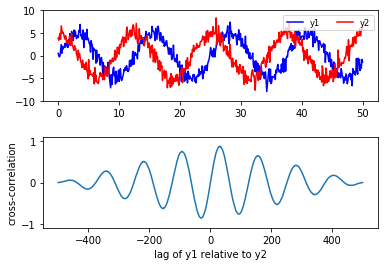

In [52]:
npts = 500
x = np.linspace(0, 50, npts)
y1 = 5 * np.sin(x/2) + np.random.randn(npts)
y2 = 5 * np.cos(x/2) + np.random.randn(npts)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
ax.set_ylim(-10, 10)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)

standard deviations:  0.9623258201568776 0.649395878125793


Text(0,0.5,'autocorrelation')

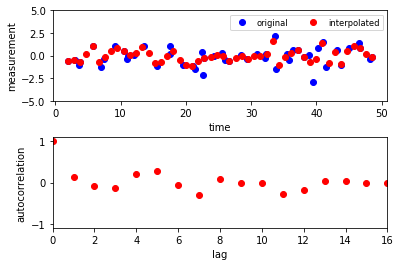

In [53]:
nt = 50
t = 2 * np.random.rand(50).cumsum()
x = np.random.randn(nt)

# Make a uniform grid, with the same number of points:
tnew = np.linspace(t.min(), t.max(), nt)
xnew = np.interp(tnew, t, x)

print("standard deviations: ", x.std(), xnew.std())

fig, (ax0, ax1) = plt.subplots(2)
fig.subplots_adjust(hspace=0.4)
ax0.plot(t, x, 'bo', label='original') 
ax0.plot(tnew, xnew, 'ro', label='interpolated')
ax0.set_xlabel('time')
ax0.set_ylabel('measurement')
ax0.legend(loc='upper right', ncol=2, fontsize='small')
ax0.set_ylim(-5, 5)

lags, auto_x = autocorr(xnew)
ax1.plot(lags, auto_x, 'ro')

for ax in (ax0, ax1):
    ax.locator_params(axis='y', nbins=4)

ax1.set_xlim(0, nt//3) # To see the smaller lags better.
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel('lag')
ax1.set_ylabel('autocorrelation')

Text(0,0.5,'ETH % Return')

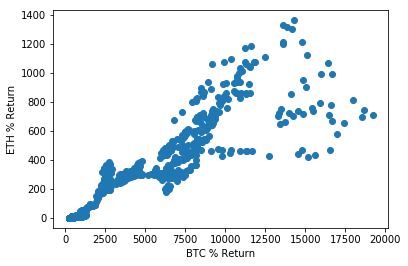

In [55]:
plt.scatter(combined_df['BTC'],combined_df['ETH'])
plt.xlabel('BTC % Return')
plt.ylabel('ETH % Return')

In [57]:
'''Simple Moving Average Crossover.'''

def CryptoData(symbol, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df


In [58]:
df = CryptoData(symbol = 'BTC_LTC', frequency = 300)

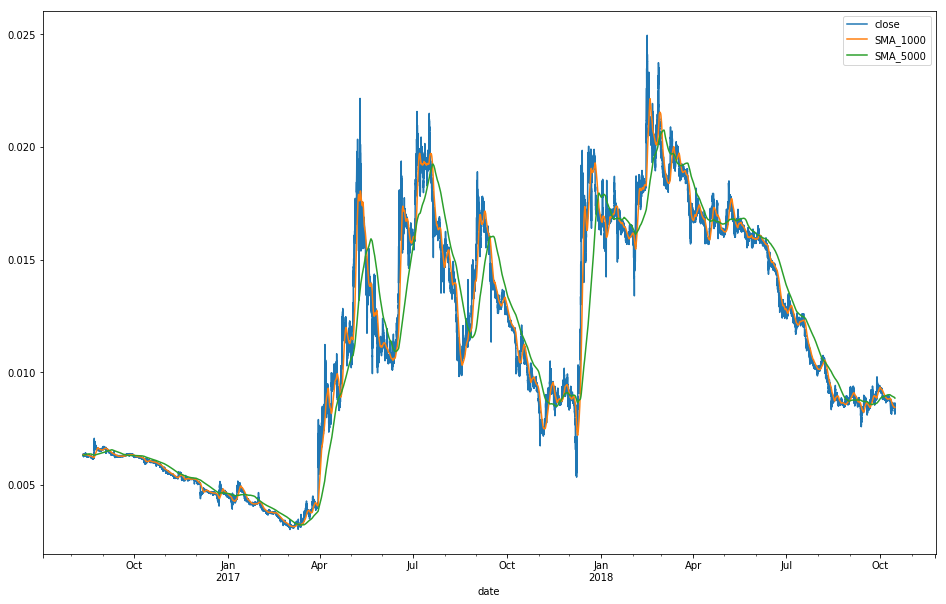

In [59]:
df['SMA_1000'] = df['close'].rolling(1000).mean() '''1000th minute average reacts to recent changes quicker than 5000th minute one'''
df['SMA_5000'] = df['close'].rolling(5000).mean()
df[['close','SMA_1000','SMA_5000']][270000:].plot(figsize = (16,10))

